In [153]:
from pathlib import Path
import os
import warnings
import sys
from pprint import pprint

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

os.chdir('/Users/tommylees/github/ml_drought')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [133]:
from src.exporters import ERA5Exporter, VHIExporter
from src.preprocess import ERA5MonthlyMeanPreprocessor, VHIPreprocessor
from src.engineer import Engineer
from src.models import LinearRegression, RecurrentNetwork, Persistence

# Exporters

In [52]:
data_dir = Path('data')
data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data2')
assert data_dir.exists()

e_exporter = ERA5Exporter(data_dir)

In [54]:
years = [2010, 2011]

for variable in ['2m_temperature', 'total_precipitation', 'evaporation']:
    e_exporter.export(variable=variable, granularity="monthly", selection_request={'year': years}, show_api_request=False)

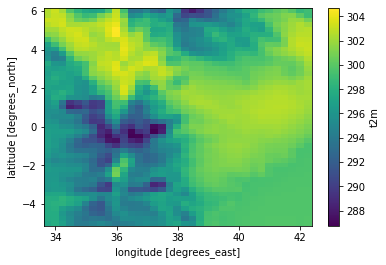

In [62]:
raw_data = xr.open_dataset(data_dir / 'raw' / 'reanalysis-era5-single-levels-monthly-means/2m_temperature/2010_2011' / '01_12.nc')
raw_data.mean(dim='time').t2m.plot()

# Preprocessors

In [57]:
e = ERA5MonthlyMeanPreprocessor(data_dir)
e.preprocess()

Reading data from /Volumes/Lees_Extend/data/ecmwf_sowc/data2/raw. Writing to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthly-means_interim
Processing 01_12.nc
selecting region: kenya from ds
Saving to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthly-means_interim/2010_01_12_2m_temperature_kenya.nc
Done for ERA5 01_12.nc
Processing 01_12.nc
selecting region: kenya from ds
Saving to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthly-means_interim/2010_2011_01_12_2m_temperature_kenya.nc
Done for ERA5 01_12.nc
Processing 01_12.nc
selecting region: kenya from ds
Saving to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthly-means_interim/2010_01_12_evaporation_kenya.nc
Done for ERA5 01_12.nc
Processing 01_12.nc
selecting region: kenya from ds
Saving to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthl

In [63]:
processed_data = xr.open_dataset(data_dir / 'interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc')
processed_data

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 24)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2011-12-31
  * lon      (lon) float32 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * lat      (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
Data variables:
    e        (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...

# Engineer

In [68]:
engineer = Engineer(data_dir, process_static=False)
engineer.engineer(test_year=2011, target_variable='e', pred_months=3, expected_length=3)

Processing /Volumes/Lees_Extend/data/ecmwf_sowc/data2/interim/reanalysis-era5-single-levels-monthly-means_preprocessed/data_kenya.nc
Generating data for year: 2011, target month: 1
Max date: 2011-01-31, max input date: 2010-12-31, min input date: 2010-09-30
Saving data to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/features/one_month_forecast/test/2011_1/x.nc
Saving data to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/features/one_month_forecast/test/2011_1/y.nc
Generating data for year: 2011, target month: 2
Max date: 2011-02-28, max input date: 2011-01-31, min input date: 2010-10-31
Saving data to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/features/one_month_forecast/test/2011_2/x.nc
Saving data to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/features/one_month_forecast/test/2011_2/y.nc
Generating data for year: 2011, target month: 3
Max date: 2011-03-31, max input date: 2011-02-28, min input date: 2010-11-30
Saving data to /Volumes/Lees_Extend/data/ecmwf_sowc/data2/features/one_month_for

In [71]:
[f.name for f in (data_dir / 'features' / 'one_month_forecast' / 'test').iterdir()]

['2011_1',
 '2011_10',
 '2011_11',
 '2011_12',
 '2011_2',
 '2011_3',
 '2011_4',
 '2011_5',
 '2011_6',
 '2011_7',
 '2011_8',
 '2011_9']

# Models

In [134]:
rnn = RecurrentNetwork(hidden_size=100, data_folder=data_dir, include_static=False)
lr = LinearRegression(data_dir, include_static=False)
bline = Persistence(data_dir)

In [86]:
lr.train()
lr.evaluate(save_preds=True)

Training linear_regression for experiment one_month_forecast
1.1322370708831878e-05
1.9382999686159247e-06
1.0205546292865717e-06
5.728821401949425e-06
1.5650514612800332e-06
7.552622737081063e-06
2.648170772348162e-06
2.6676895972464325e-06
5.4551662684908225e-06
5.9776213460769575e-06
2.3583780053839205e-06
7.184275782145047e-06
2.731107145254638e-06
3.9354981810229935e-06
2.769700666623372e-06
3.88128594519348e-06
5.792869968843382e-06
4.802258927488787e-06
4.737921569607665e-06
4.252921423606261e-06
2.9456662064880795e-06
4.7726267697127315e-06
2.292425895014353e-06
8.435936397326903e-06
2.9038630327163353e-06
2.5835635156589815e-06
6.0701439403362215e-06
4.5951675135812135e-06
4.812951015101491e-06
7.470241449377164e-06
2.725912107267418e-06
5.696216749184744e-06
3.4959161932038135e-06
1.5552038276889473e-05
2.7701413237384938e-06
8.16532074605504e-06
7.7866035405585e-06
1.3638618550923998e-05
9.497302832906301e-06
8.297284406342265e-06
7.164319554397824e-06
5.579557811949418e-06


In [106]:
rnn.train(num_epochs=10)
rnn.evaluate(save_preds=True)

Training rnn for experiment one_month_forecast
Epoch 1, train smooth L1: 0.0008137960864621198, RMSE: 0.03692509359345953
Epoch 2, train smooth L1: 0.000647101538426661, RMSE: 0.03103160036095849
Epoch 3, train smooth L1: 0.0003783840474406369, RMSE: 0.022087829039238234
Epoch 4, train smooth L1: 0.0005017721295425199, RMSE: 0.02523265416349918
Epoch 5, train smooth L1: 0.00045030032562728457, RMSE: 0.026585398043913726
Epoch 6, train smooth L1: 0.0002697667897859059, RMSE: 0.020370376139065848
Epoch 7, train smooth L1: 0.0002727014115096069, RMSE: 0.01831779745113059
Epoch 8, train smooth L1: 0.0003206072781604571, RMSE: 0.02053583021226506
Epoch 9, train smooth L1: 0.0003620287955830766, RMSE: 0.018395066282705024
Epoch 10, train smooth L1: 0.00021853237488492731, RMSE: 0.016827546384427267
Epoch 11, train smooth L1: 7.912453171835902e-05, RMSE: 0.009984615065476406
Epoch 12, train smooth L1: 0.00014029346770830334, RMSE: 0.013975406686856338
Epoch 13, train smooth L1: 0.000213072822

In [135]:
bline.train()
bline.evaluate(save_preds=True)

RMSE: 0.0006736067007295787


# Analysis

In [136]:
[f.name for f in (data_dir / 'models' / 'one_month_forecast' / 'rnn').iterdir()]

['preds_2011_1.nc',
 'preds_2011_10.nc',
 'preds_2011_11.nc',
 'preds_2011_12.nc',
 'preds_2011_2.nc',
 'preds_2011_3.nc',
 'preds_2011_4.nc',
 'preds_2011_5.nc',
 'preds_2011_6.nc',
 'preds_2011_7.nc',
 'preds_2011_8.nc',
 'preds_2011_9.nc',
 'results.json']

In [150]:
from src.analysis import read_pred_data, read_true_data
from src.analysis import annual_scores

In [172]:
rnn_preds, _ = read_pred_data(data_dir=data_dir, model='rnn')
lr_preds, _ = read_pred_data(data_dir=data_dir, model='linear_regression')
bline_preds, _ = read_pred_data(data_dir=data_dir, model='previous_month')
y_test = read_true_data(data_dir, variable='e')

rnn_preds = rnn_preds.compute()
pprint(rnn_preds)

<xarray.Dataset>
Dimensions:  (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat      (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon      (lon) float64 33.75 34.0 34.25 34.5 34.75 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2011-01-31 2011-02-28 ... 2011-12-31
Data variables:
    preds    (lat, lon, time) float32 0.12057733 -0.14767563 ... -0.056904607


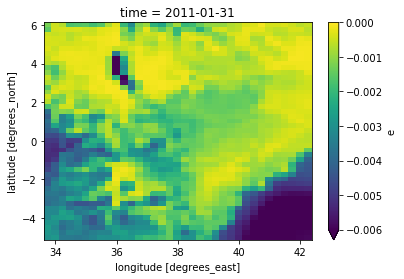

In [177]:
y_test.isel(time=0).plot(vmin=-0.006, vmax=0)

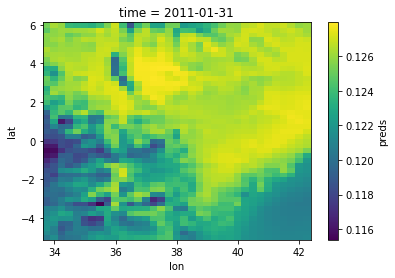

In [180]:
rnn_preds.preds.isel(time=0).plot()

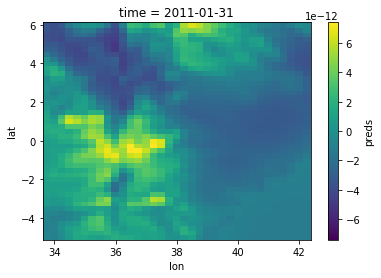

In [181]:
lr_preds.preds.isel(time=0).plot(cmap='viridis')

In [140]:
df = annual_scores(
    models=['linear_regression', 'rnn', 'previous_month'], data_path=data_dir, pred_year=2011, target_var='e', to_dataframe=True, verbose=False
)
df.head()

,linear_regression,month,previous_month,rnn,year,metric
0,0.002381,1.0,0.000534,0.126224,2011.0,rmse
1,0.002310,2.0,0.000401,0.145903,2011.0,rmse
2,0.002123,3.0,0.000488,0.175159,2011.0,rmse
3,0.002320,4.0,0.000501,0.011092,2011.0,rmse
4,0.002387,5.0,0.000828,0.051638,2011.0,rmse


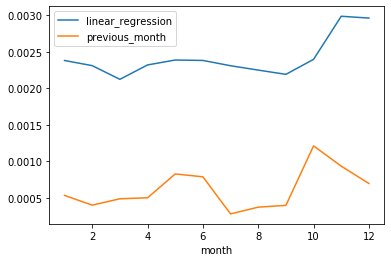

In [147]:
df.where(df.metric == 'rmse').drop(columns=['year', 'rnn']).plot(x='month')

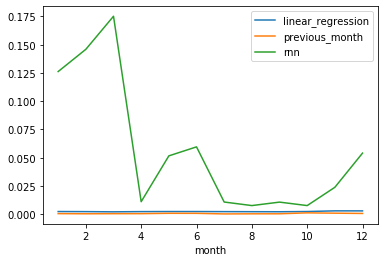

In [149]:
df.where(df.metric == 'rmse').drop(columns=['year']).plot(x='month');